<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Install PySR and PyTorch-Lightning:

In [ ]:
%pip install -Uq pysr pytorch_lightning --quiet

In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.3 LTS
  uname: Linux 5.15.120+ #1 SMP Wed Aug 30 11:19:59 UTC 2023 x86_64 x86_64
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz: 
              speed         user         nice          sys         idle          irq
       #1  2199 MHz      19051 s          0 s       1577 s      30044 s          0 s
       #2  2199 MHz      20068 s          0 s       1569 s      29057 s          0 s
  Memory: 12.6783447265625 GB (11583.8359375 MB free)
  Uptime: 5090.17 sec
  Load Avg:  1.3  1.51  1.54
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 1 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_PROJECT = @pysr-0.16.3
  JULIA_PKG_PRECOMPILE_AUTO = 0
  TCLLIBPATH = /usr/share/tcltk/tcllib1.20
  HOME = /root
  PYTHONPATH = /env/python
  LIBRARY_PATH = /usr/local/cuda/lib64/stubs
  PATH = /opt/bin:/usr/local/nvidia/b

[ Info: Julia version info
[ Info: Julia executable: /usr/local/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /usr/bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /usr/bin/python3
└     libpython: 
    Updating registry at `~/.julia/registries/General.toml`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:118: UserWarning: It is recommended to restart Python after installing PySR's dependencies, so that the Julia environment is properly initialized.
  warnings.warn(


In [ ]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/sciml_project/main/analysis_data.csv')

tx_girders = {'Tx28' : {'D' : 28.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 6.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx34' : {'D' : 34.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 12.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx40' : {'D' : 40.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 18.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx46' : {'D' : 46.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 22.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx54' : {'D' : 54.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 30.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx62' : {'D' : 62.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 37.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx70' : {'D' : 70.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 45.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx84' : {'D' : 84.0, 'b1' : 58.0, 'b2' : 8.0, 'b3' : 38.0, 'b4' : 3.0, 'b5' : 3.0, 'd1' : 4.0, 'd2' : 3.5, 'd3' : 3.0, 'd4' : 55.75, 'd5' : 3.0, 'd6' : 6.0, 'd7' : 8.75}
              }

# bridge geometry data
L = df['L']/12 # span length in ft.
S = df['S']/12 # girder spacing in ft.
w_oh = df['w_oh']/12 # overhang width in ft.
ts = df['ts_U']/12 # thickness of overhang in ft.
girder = df['Girder Type']
D = []
for _, girder_type in girder.items():
  D.append(tx_girders[girder_type]['D'])
df['D'] = D

# intensity of railing dead load in kip/ft
b_rail = df['b_rail_left'] # width of railing
q_rail = (df['q_rail_left'] * b_rail * 12)/1000

# max bending moment in exterior girder G1 & interior girder G2 in kip-ft
bm1 = df['G1 - max_bm']/(1000*12)
bm2 = df['G2 - max_bm']/(1000*12)
bm3 = df['G3 - max_bm']/(1000*12)
bm4 = df['G4 - max_bm']/(1000*12)

# reaction in girders G1 & G2 in kip. (only A1 taken due to symmetry)
r1 = df['G1-A1-Y']/1000
r2 = df['G2-A1-Y']/1000
r3 = df['G3-A1-Y']/1000
r4 = df['G4-A1-Y']/1000

# line analysis with full railing load assumed to be applied on a girder
bm_line = q_rail * (L - 2*9/12)**2 / 8
r_line = q_rail * L / 2


# normalizing bending moments with respect to line analysis
n_bm1 = bm1 / bm_line
n_bm2 = bm2 / bm_line
n_bm3 = bm3 / bm_line
n_bm4 = bm4 / bm_line

# normalizing vertical reactions with respect to line analysis
n_r1 = r1 / r_line
n_r2 = r2 / r_line
n_r3 = r3 / r_line
n_r4 = r4 / r_line

# add the distribution factors to the dataframe
df['n_bm1'] = n_bm1
df['n_bm2'] = n_bm2
df['n_bm3'] = n_bm3
df['n_bm4'] = n_bm4
df['n_r1'] = n_r1
df['n_r2'] = n_r2
df['n_r3'] = n_r3
df['n_r4'] = n_r4

In [ ]:
# sample data from leve rule
# n_r1 = (w_oh + S) / S

In [ ]:
X = np.stack((L, w_oh, S), axis=-1)
y = n_r1

In [ ]:
# Learn equations
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:231: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:109: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(


Started!

Expressions evaluated per second: 1.160e+04
Head worker occupation: 0.7%
Progress: 23 / 600 total iterations (3.833%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           6.037e-03  1.594e+01  y = 0.98913
2           6.017e-03  3.307e-03  y = cube(0.99486)
4           5.958e-03  4.893e-03  y = (0.98913 ^ inv(x₁))
5           5.710e-03  4.247e-02  y = (0.96995 ^ physics(0.8505, x₁))
6           3.241e-03  5.665e-01  y = sqrt(sqrt(square(0.57979) * x₁))
7           2.313e-03  3.373e-01  y = sqrt(inv(sqrt(square(1.5948) / x₁)))
9           1.351e-03  2.688e-01  y = sqrt(sqrt(x₁ * ((x₂ / x₀) + 0.27831)))
11          1.108e-03  9.893e-02  y = sqrt(sqrt(x₁ * (((x₂ + x₁) / x₀) + 0.22345)))
12          9.870e-04  1.161e-01  y = sqrt(sqrt(x₁ * (((square(-1.6043) + x₂) / x₀) + 0.22345)))
16          9.857e-04  3.445e-04  y = sqrt(sqrt(x₁ * (((square(physics(-0.81028, x₀) -

In [ ]:
model.sympy()

1.30806823795089*(x1**2/x0)**0.11593429

In [ ]:
n_r1_pred = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Default selection MSE: 0.0008611227054812625
Manual selection MSE for index 2: 0.0052227593268557556


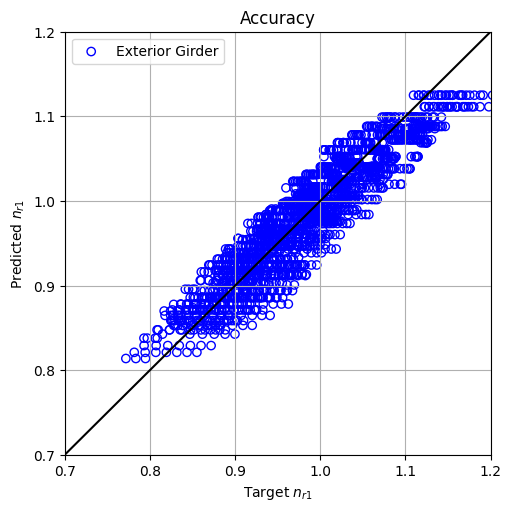

In [ ]:
x_line = [0.5, 1.5]
y_line = [0.5, 1.5]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r1, y=n_r1_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.7,1.2))
plt.ylim((0.7,1.2))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()